# Jet unc

This notebook is aimed at calculating the uncertainty derived from the jet momentum scale uncertainty. 
To understand the effect we plot the WW jet multiplicity before and after applying a momentum scale shift. 
The momentum scale uncertainty for jets is roughly 2.5%. 
We multiply momentum of each jet by 1.025 and 0.975, and recalculate associated measureables. 
Then apply jet selection criteria and measure how the jet multiplicity changed.
We repeat the process for final selection.


To measure the uncertainty on the final cross-section measurement we apply the process described above and calculate the cross-section for each chase.
After which we take the average difference between these two cases and the nominal value and take that as the uncertainty do to Jet momentum scale.

In [1]:
#Set up
import os, sys
sys.path.append(os.getcwd() + "/../")
from prep_ana_II import *
sys.path.append(os.getcwd() + "/../tools/")
sys.path.append(os.getcwd() + "/../tools/jecsys/")
from JECUncertainty import JECUncertainty, jecUncertainties
from lepton_eff import muonEff, electronEff
from pile_up import pileUpFunction, Min_Bias
from cross_section_calc import calc_cross_stuff, cross_calc, stat_unc_calc, normalization_unc_calc

import matplotlib
matplotlib.rcParams.update({'font.size': 24,
                            #"text.color": "grey",
                            #"axes.labelcolor": "grey",
                            #"xtick.color": "grey",
                            #"ytick.color": "grey",
                           #"axes.facecolor" : (.4, .4, .4)
                           })
import warnings
warnings.filterwarnings('ignore')

Welcome to JupyROOT 6.10/00
Loading binning options...
Loading plotting options
unc_mc_process and scales are parameter dictionaries


In [2]:
%matplotlib inline

In [3]:
rfs = load_randomForest()
jec_obj = JECUncertainty()

In [5]:
df = load_presel_w_fDY_fTT_MC()
df_da = load_presel_w_fDY_fTT_DATA()

df_ww = rp.read_root(data_path+"/ww_complete.root", columns=columns)

df["org_numb_jets"] = 1 * df.numb_jets.values
df_da["org_numb_jets"] = 1 * df_da.numb_jets.values

Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class string read from file /home/gunter/WW_analysis/data_alpha/ww_complete.root
   has the same version (=2) as the active class but a different checksum.
   You should update the version to ClassDef(string,3).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 2 of class 'string' is missing from 
the on-file layout version 2:
   string::_Alloc_hider _M_dataplus; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 2 of class 'string' is missing from 
the on-file layout version 2:
   unsigned long _M_string_length; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 2 of class 'string' is missing from 
the on-file layout version 2:
   string::(anonymous) ; //


## Edit jet content

There are two functions that perform the bulk of this analysis, `kill_jets` and `jet_scale_shift`. 
`kill_jets` reapplys the jet selection criteria while `jet_scale_shift` applys the jet momentum scale shift, calls `kill_jets` and 
calls the random forest classifier to score the new dataset. 

In [5]:
def kill_jets( df, pt_cut= 30.5 ):
    #Edit number of jets per event
    n_jets = np.zeros(df.shape[0])
    for k in df.keys():
        if "jet" in k and "pt" in k:
            print k
            cut = (df[k] > pt_cut)
            n_jets[cut.values] = n_jets[cut.values] + 1 

    df["numb_jets"] = n_jets
   

In [6]:
def jet_scale_shift(data, jet_pt=1.025, pt_cut= 30.5, rf=None): #2.5% jet scale
    #jets
    data.HT = data.HT * 0
    #Scale pt of each jet
    for k in df.keys():
        if "jet" in k and "pt" in k:
            data[k] = data[k] * jet_pt
            #NEW TO CORRECT FOR EVENTS WITH LOST JETS
            ht_lost_jet = data[k] >= pt_cut
            data.HT.values[ht_lost_jet] = data[ht_lost_jet].HT + data[ht_lost_jet][k]

    #MET results
    data.metMod  = data.metMod - data.HT / jet_pt * (jet_pt - 1)
    data.metProj = data.METProj - data.HT / jet_pt * (jet_pt - 1)
    data.recoil  = data.recoil - data.HT / jet_pt * (jet_pt - 1)
    
    #Update number of jets
    kill_jets( data, pt_cut )
    if rf != None:
    #print "Recreating random forest scores."
        pred_fTT = rf["clf_fTT"].predict_proba(np.float32(data[rf["features_fTT"]].values))
        data["fTT"] = pred_fTT[:,0]

        temp = data[rf["features_fDY"]]
        temp = temp.replace([np.inf,-np.inf], 0)
        pred_fDY = rf["clf_fDY"].predict_proba(np.float32(temp.values))
        data["fDY"] = pred_fDY[:,0]



In [7]:
def rf_ana(df, fDY, fTT):
    fDY = df[fDY] > .9
    fTT = df[fTT] > .6
    
    return df[fDY & fTT]


## Applying To Data

In [9]:
#Orginal fiducial cross section:
kwargs = calc_cross_stuff(df, df_da, df_ww, scales, flavor="both")
X_section_orig = cross_calc(df, df_da, df_ww, scales, fiducial=True, **kwargs)
print X_section_orig

4.04244021357


### Low Scale shift



In [9]:
jet_scale_shift(df, jet_pt=0.975, pt_cut= 30, rf=rfs)

jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt


#### Preselection plots

What do we expect: The jet pt is shifted down by 2.5% meaning we'd expect our zero jet bin to exceed the original jet distribution while subsequent jet bins should fall below. This is especially true for events with high jet multiplicty for they often have jet with lower pt. 

What we exoect aligns with what was seen.

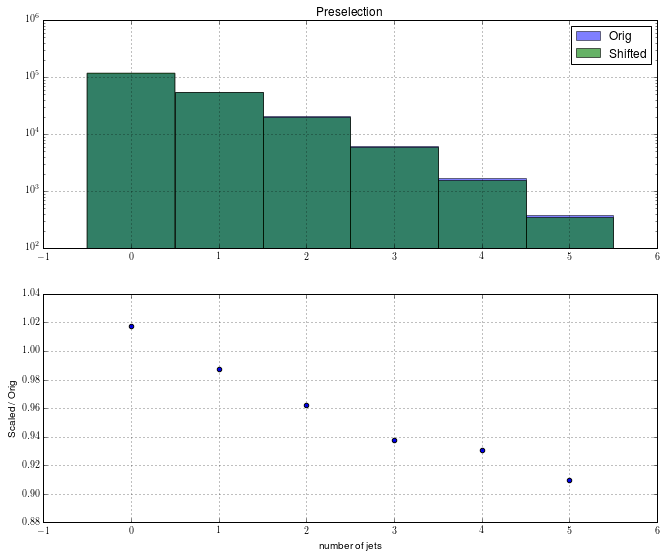

In [10]:
#Preselection stuff
plt.figure(1, figsize=(11, 9))
plt.subplot(211)
df[df.process == "WW"].org_numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.5)
df[df.process == "WW"].numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.6)
plt.legend(["Orig", "Shifted"])
plt.yscale("log")
plt.title("Preselection")

plt.subplot(212)
histogram_org = np.histogram(df[df.process == "WW"].org_numb_jets, bins=6, range=(-0.5, 5.5))
histogram_s = np.histogram(df[df.process == "WW"].numb_jets, bins=6, range=(-0.5, 5.5))
plt.grid(True)

plt.scatter( [i for i in xrange(histogram_org[0].shape[0])], histogram_s[0].astype(float) / histogram_org[0])
plt.ylabel("Scaled / Orig")
plt.xlabel("number of jets")

#### RFselection plots

After applying a jet momentum shift to the dataset one would expect that the jet multiplicity after 
random forest scoring would go as follows:

The lower jet bins would show an excess. The resason being two fold.  There are now more events in the low jet bin region and  WW events occupy lower jet muliplicities. 

What we expect did not align with what was seen. It could be from how we handle HT, met ... For HT paricularly we do not subtract the momentum of jets that are now excluded by our jet selection criteria. 

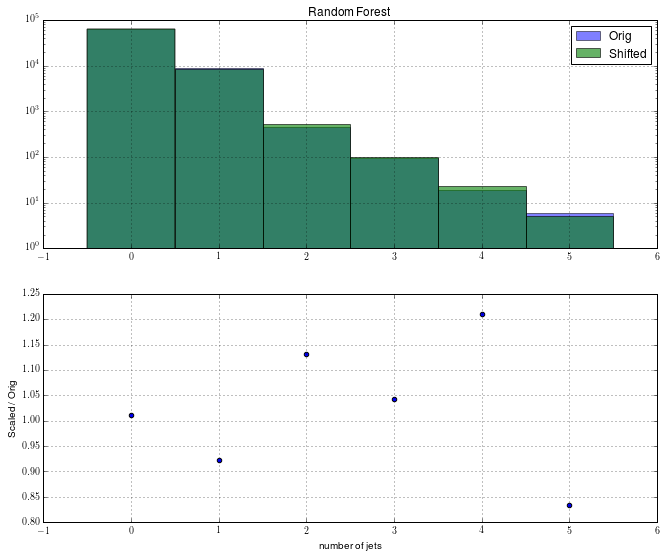

In [11]:
plt.figure(1, figsize=(11, 9))
plt.subplot(211)
rf_ana(df[df.process == "WW"], "pred_fDY_WW", "pred_fTT_WW").org_numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.5)
rf_ana(df[df.process == "WW"], "fDY", "fTT").numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.6)
plt.legend(["Orig", "Shifted"])
plt.yscale("log")
plt.title("Random Forest")

plt.subplot(212)
histogram_org = np.histogram(rf_ana(df[df.process == "WW"], "pred_fDY_WW", "pred_fTT_WW").org_numb_jets, bins=6, range=(-0.5, 5.5))
histogram_s = np.histogram(rf_ana(df[df.process == "WW"], "fDY", "fTT").numb_jets, bins=6, range=(-0.5, 5.5))
plt.grid(True)

plt.scatter( [i for i in xrange(histogram_org[0].shape[0])],  histogram_s[0].astype(float) / histogram_org[0])
plt.ylabel("Scaled / Orig")
plt.xlabel("number of jets")

#### Results

Applying to cross-section

In [12]:
#fiducial cross section:
df["org_fDY"] = 1. * df.pred_fDY_WW.values
df["org_fTT"] = 1. * df.pred_fTT_WW.values

df.pred_fDY_WW = 1. * df.fDY.values
df.pred_fTT_WW = 1. * df.fTT.values
kwargs = calc_cross_stuff(df, df_da, df_ww, scales, flavor="both")
X_section = cross_calc(df, df_da, df_ww, scales, fiducial=True, **kwargs)
print X_section_orig, X_section, abs(X_section_orig - X_section)

df.pred_fDY_WW = 1. * df.org_fDY.values
df.pred_fTT_WW = 1. * df.org_fTT.values

4.04244021357 4.00991260407 0.0325276094997


### High Scale shift

In [13]:
#re-align with the original dataset. And set original numb_jets 
jet_scale_shift(df, jet_pt=1./0.975, rf=rfs)
df.org_numb_jets = 1. * df.numb_jets

kwargs = calc_cross_stuff(df[((df.jet1_pt > 30.5) | (df.jet1_pt == 0)) & ((df.jet2_pt > 30.5) | (df.jet2_pt == 0))], df_da, df_ww, scales, flavor="both")
X_section_orig = cross_calc(df[((df.jet1_pt > 30.5) | (df.jet1_pt == 0)) & ((df.jet2_pt > 30.5) | (df.jet2_pt == 0))], df_da, df_ww, scales, fiducial=True, **kwargs)

#Calc apply new scale shift
jet_scale_shift(df, jet_pt=1./0.975, rf=rfs)

jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt
jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt


#### Preselection

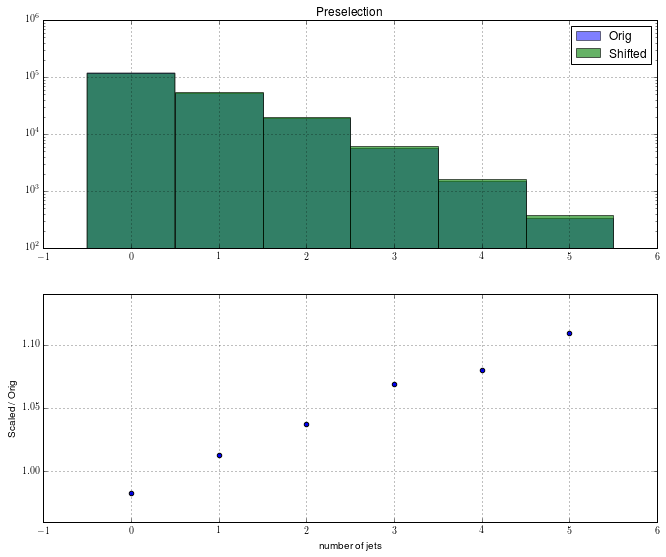

In [14]:
plt.figure(1, figsize=(11, 9))
plt.subplot(211)
jet_pt_selection = ((df.jet1_pt > 31. * 0.975) | (df.jet1_pt == 0)) &\
                    ((df.jet2_pt > 31. * 0.975) | (df.jet2_pt == 0))&\
                    ((df.jet3_pt > 31. * 0.975) | (df.jet3_pt == 0))&\
                    ((df.jet4_pt > 31. * 0.975) | (df.jet4_pt == 0))&\
                    ((df.jet5_pt > 31. * 0.975) | (df.jet5_pt == 0))
df[jet_pt_selection][df.process == "WW"].org_numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.5)
df[df.process == "WW"].numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.6)
plt.legend(["Orig", "Shifted"])
plt.yscale("log")
plt.title("Preselection")

plt.subplot(212)
histogram_org = np.histogram(df[df.process=="WW"].org_numb_jets, bins=6, range=(-0.5, 5.5))
histogram_s = np.histogram(df[df.process == "WW"].numb_jets, bins=6, range=(-0.5, 5.5))
plt.grid(True)

plt.scatter( [i for i in xrange(histogram_org[0].shape[0])], histogram_s[0].astype(float) /  histogram_org[0])
plt.ylabel("Scaled / Orig")
plt.xlabel("number of jets")

#### RFselection

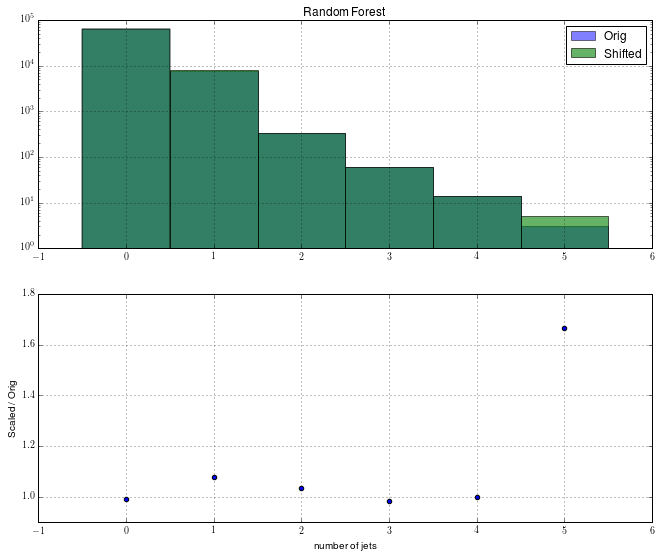

In [17]:
plt.figure(1, figsize=(11, 9))
plt.subplot(211)
#rf_ana(df[df.process == "WW"], "pred_fDY_WW", "pred_fTT_WW").org_numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.5)
rf_ana(df[jet_pt_selection][df.process == "WW"], "pred_fDY_WW", "pred_fTT_WW").org_numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.5)
rf_ana(df[df.process == "WW"], "fDY", "fTT").numb_jets.hist(bins=6, range=(-0.5, 5.5), alpha=0.6)
plt.legend(["Orig", "Shifted"])
plt.yscale("log")
plt.title("Random Forest")

plt.subplot(212)
histogram_org = np.histogram(rf_ana(df[df.process == "WW"], "pred_fDY_WW", "pred_fTT_WW").org_numb_jets, bins=6, range=(-0.5, 5.5))
histogram_s = np.histogram(rf_ana(df[df.process == "WW"], "fDY", "fTT").numb_jets, bins=6, range=(-0.5, 5.5))
plt.grid(True)

plt.scatter( [i for i in xrange(histogram_org[0].shape[0])],  histogram_s[0].astype(float) /  histogram_org[0])
plt.ylabel("Scaled / Orig")
plt.xlabel("number of jets")

#### Results

In [16]:
#Orginal fiducial cross section:

df.pred_fDY_WW = 1. * df.fDY.values
df.pred_fTT_WW = 1. * df.fTT.values
kwargs = calc_cross_stuff(df, df_da, df_ww, scales, flavor="both")
X_section = cross_calc(df, df_da, df_ww, scales, fiducial=True, **kwargs)
print X_section_orig, X_section, abs(X_section_orig - X_section)

4.04985915355 4.07431626293 0.0244571093779


# Jet scale efficiencies uncertainties

We define effect of jet momentum scale uncertainties for WW as:

$$\bar{\epsilon} = \frac{\epsilon_{0} N_{0} + \epsilon_{1} N_{1} + \epsilon_{2} N_{2} + \ldots} { N_{0} + N_{1} + N_{2} + \ldots}$$

Where $\epsilon_{i}$ is the efficiency of the WW after we apply all analysis cuts. 

In [ ]:
df = load_presel_w_fDY_fTT_MC()
df_da = load_presel_w_fDY_fTT_DATA()

df_ww = rp.read_root(data_path+"/ww_complete.root", columns=columns)

df["org_numb_jets"] = 1 * df.numb_jets.values
df_da["org_numb_jets"] = 1 * df_da.numb_jets.values

In [27]:
#With preselection cuts, org rf
pre_sel_ww = np.histogram(df_ww[df_ww.process == "WW"].numb_jets.values, bins=7, range=(-0.5, 6.5), )[0].astype(float)
pre_rfsel_ww = np.histogram(rf_ana(df[df.process == "WW"], "pred_fDY_WW", "pred_fTT_WW").numb_jets.values, bins=7, range=(-0.5, 6.5), )[0].astype(float)

#Apply shift With shift preselection, with rf
jet_scale_shift(df, jet_pt=0.975, pt_cut= 30, rf=rfs)
pre_shift_rfsel_low = np.histogram(rf_ana(df[df.process == "WW"], "fDY", "fTT").numb_jets.values, bins=7, range=(-0.5, 6.5), )[0].astype(float)

#Apply shift With shift preselection, with rf
jet_scale_shift(df, jet_pt=1.025, pt_cut= 31, rf=rfs)
jet_scale_shift(df, jet_pt=1.025, pt_cut= 31, rf=rfs)
pre_shift_rfsel_high = np.histogram(rf_ana(df[df.process == "WW"], "fDY", "fTT").numb_jets.values, bins=7, range=(-0.5, 6.5), )[0].astype(float)

jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt
jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt
jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt


In [31]:
epsilon_low = ( ( pre_rfsel_ww / pre_sel_ww ) * pre_shift_rfsel_low ).sum() / pre_shift_rfsel_low.sum()
epsilon_high = ( ( pre_rfsel_ww / pre_sel_ww ) * pre_shift_rfsel_high ).sum() / pre_shift_rfsel_high.sum()
epsilon_orig = ( ( pre_rfsel_ww / pre_sel_ww ) * pre_shift_rfsel_high ).sum() / pre_rfsel_ww.sum()

In [46]:
print "Epsilon: ", pre_rfsel_ww / pre_sel_ww 

Epsilon:  [ 0.52868945  0.14642069  0.01709188  0.00988468  0.00879397  0.0132626   0.        ]


In [45]:
print "\t epsilon \t bar epsilon \t N jets"
print "Low:  ", epsilon_low, abs(epsilon_low - epsilon_orig) / epsilon_orig, [i for i in pre_shift_rfsel_low[:4]]
print "High: ", epsilon_high, abs(epsilon_high - epsilon_orig) / epsilon_orig, [i for i in pre_shift_rfsel_high[:4]]
print "Orig: ", epsilon_orig
print "Tot jet scale unc: ", (abs(epsilon_low - epsilon_orig) + abs(epsilon_high - epsilon_orig) )/ (2. * epsilon_orig )

	 epsilon 	 bar epsilon 	 N jets
Low:   0.477314324206 0.00552809963423 [62682.0, 8920.0, 462.0, 94.0]
High:  0.485761531506 0.0120714356639 [62682.0, 7518.0, 235.0, 48.0]
Orig:  0.479967633103
Tot jet scale unc:  0.00879976764908


In [47]:
0.008799 * 4.04

0.035547959999999997

# JetMET POG correction uncertainties

In [8]:
temp = jecUncertainties( list(df_ww[df_ww.jet1_pt > 30].jet1_pt.values[:5000]),
                        list(df_ww[df_ww.jet1_pt > 30].jet1_eta.values[:5000]), jec_obj)
temp = np.array(temp)

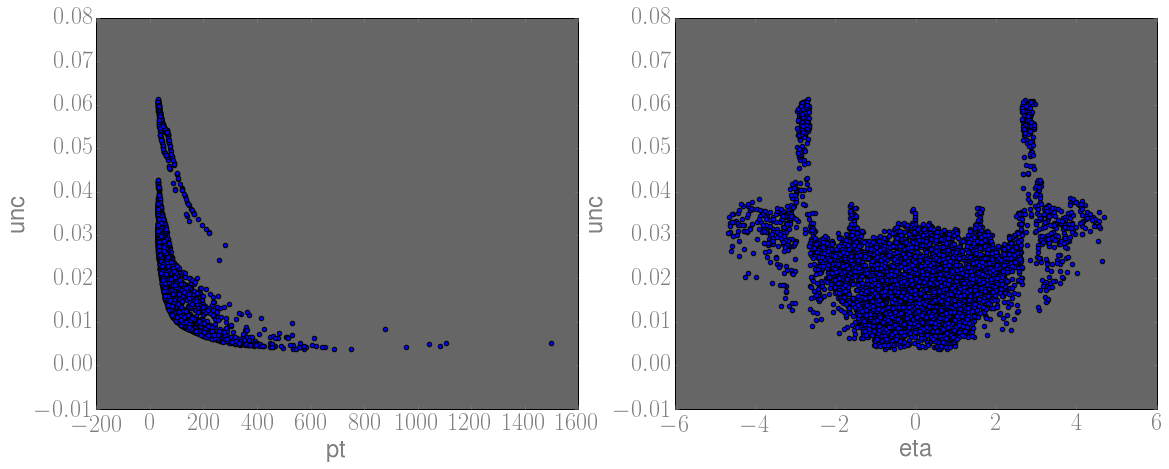

In [12]:
plt.figure(1, figsize=(19,7))
plt.subplot(121)
plt.scatter(df_ww[df_ww.jet1_pt > 30].jet1_pt.values[:5000], temp, )
plt.xlabel("pt")
plt.ylabel("unc")

plt.subplot(122)
plt.scatter(df_ww[df_ww.jet1_pt > 30].jet1_eta.values[:5000], temp, )
plt.xlabel("eta")
plt.ylabel("unc")

plt.show()

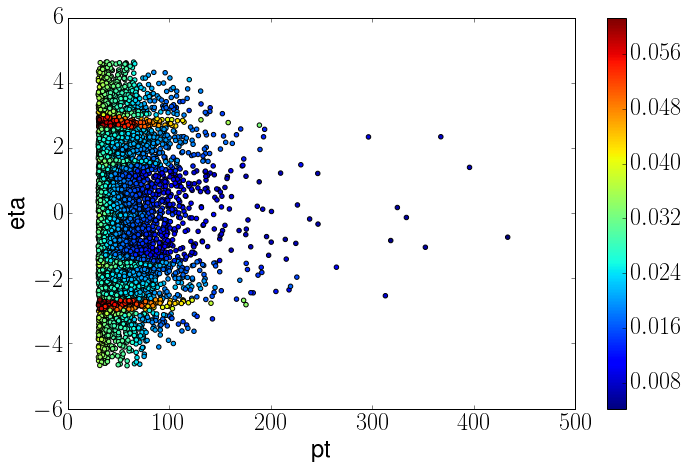

In [11]:
plt.figure(1, figsize=(25,7))
plt.subplot(121)
plt.scatter(df_ww[df_ww.jet1_pt > 30].jet1_pt.values[:5000],
            df_ww[df_ww.jet1_pt > 30].jet1_eta.values[:5000],
           c=temp)

plt.ylabel("eta")
plt.xlabel("pt")
plt.colorbar()

In [6]:
pt_data = df_ww[df_ww.jet1_pt > 30].jet1_pt.values[:5000]
eta_data = df_ww[df_ww.jet1_pt > 30].jet1_eta.values[:5000]

In [9]:
#average bin unc for pt and eta remake above plot
pt_bins = [10] * 7 + [50] * 6 + [10000]
eta_bins = [1] * 10

bins = np.zeros((len(pt_bins), len(eta_bins)))
#Iterate over bins and average ....
pt_ = 30.
for it, pt in enumerate(pt_bins):
    #print "pt:", pt_, pt_ + pt
    eta_ = -5.
    for jt, eta in enumerate(eta_bins):
        #print "eta:", eta_, eta_ + eta
        
        bins[it][jt] = temp[(pt_data >= pt_) & (pt_data < pt_ + pt) & (eta_data >= eta_) & (eta_data < eta_ + eta)].mean()
        eta_ += eta
    pt_ += pt
    
bins[np.isnan(bins)] = bins[~np.isnan(bins)].max()

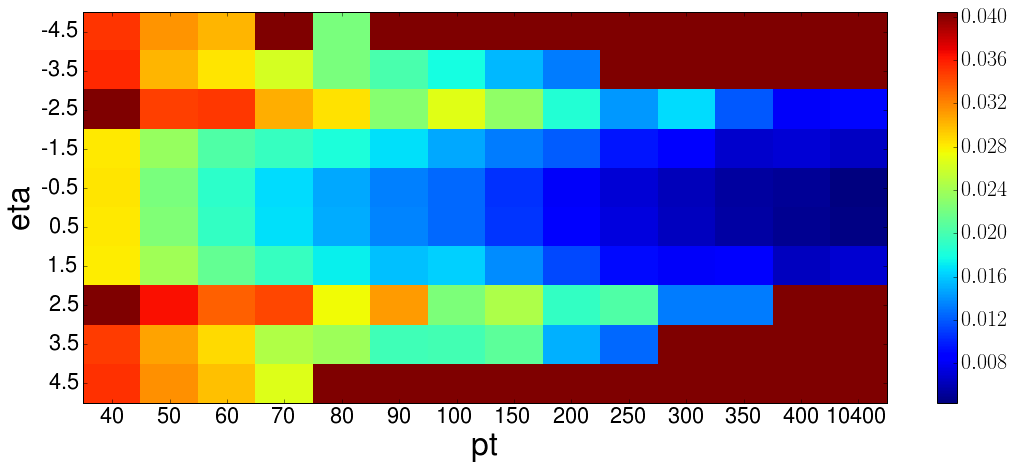

In [15]:
plt.figure( figsize=(18,7))
plt.imshow(np.rot90(bins), interpolation='nearest',  aspect='auto')

x = [i for i in range(14)]
x_l = []
x_ = 30
for i in range(14):
    x_ = x_ + pt_bins[i]
    x_l.append( x_ )

matplotlib.rcParams.update({'font.size': 22})
plt.xticks(x, x_l)#np.array(pt_bins) + np.array(x) + 25)

y = [i for i in range(10)]
plt.yticks(y, np.array(eta_bins) + np.array(y) - 5.5)

plt.ylabel("eta", fontsize=32)
plt.xlabel("pt", fontsize=32)
plt.colorbar()

In [27]:
#Apply binned uncertainty to WW and see how jet bin hist change
#bins, pt_bins, eta_bins

for k in df_ww.keys():
    if "jet" in k and "eta" in k:
        df_ww[ k[:-3]+"unc"] = 0.

pt_ = 30
for it, pt in enumerate(pt_bins):
    #print "pt:", pt_, pt_ + pt
    eta_ = -5
    for jt, eta in enumerate(eta_bins):
        #print "eta:", eta_, eta_ + eta
        for k in df_ww.keys():
            if "jet" in k and "eta" in k:
                selection = (df_ww[k[:-3] + "pt"] >= pt_) &\
                            (df_ww[k[:-3] +"pt"] < pt_ + pt) &\
                            (df_ww[k] >= eta_) &\
                            (df_ww[k] < eta_ + eta)
                df_ww[k[:-3]+"unc"].values[selection] = bins[it][jt]

        eta_ += eta
    pt_ += pt
    
print df_ww[["jet1_pt", "jet1_unc", "jet2_pt", "jet2_unc"]][:10]

     jet1_pt  jet1_unc    jet2_pt  jet2_unc
0   0.000000  0.000000   0.000000  0.000000
1  54.505821  0.035219   0.000000  0.000000
2   0.000000  0.000000   0.000000  0.000000
3   0.000000  0.000000   0.000000  0.000000
4   0.000000  0.000000   0.000000  0.000000
5   0.000000  0.000000   0.000000  0.000000
6   0.000000  0.000000   0.000000  0.000000
7  60.660862  0.016628  33.975147  0.027928
8  32.401146  0.028328   0.000000  0.000000
9  85.486244  0.014908   0.000000  0.000000


In [28]:
def jet_scale_shift_new(data, pt_cut= 30.5, up_down="up", rf=None): #2.5% jet scale
    #jets
    data.HT = data.HT * 0
    #Scale pt of each jet
    if up_down == "up":
        thingoo = 1
    else:
        thingoo = -1
    for k in data.keys():
        if "jet" in k and "unc" in k:
            data[k[:-3]+"pt"] = data[k[:-3]+"pt"] * np.abs(thingoo + data[k])
            #NEW TO CORRECT FOR EVENTS WITH LOST JETS
            ht_lost_jet = data[k[:-3] + "pt"] >= pt_cut
            data.HT.values[ht_lost_jet] = data[ht_lost_jet].HT + data[ht_lost_jet][k]

    #MET results
    #data.metMod  = data.metMod - data.HT / jet_pt * (jet_pt - 1)
    #data.metProj = data.METProj - data.HT / jet_pt * (jet_pt - 1)
    #data.recoil  = data.recoil - data.HT / jet_pt * (jet_pt - 1)
    
    #Update number of jets
    kill_jets( data, pt_cut )
    if rf != None:
    #print "Recreating random forest scores."
        pred_fTT = rf["clf_fTT"].predict_proba(np.float32(data[rf["features_fTT"]].values))
        data["fTT"] = pred_fTT[:,0]

        temp = data[rf["features_fDY"]]
        temp = temp.replace([np.inf,-np.inf], 0)
        pred_fDY = rf["clf_fDY"].predict_proba(np.float32(temp.values))
        data["fDY"] = pred_fDY[:,0]



In [33]:
#Original
jet_scale_shift(df_ww, jet_pt=1, rf=rfs)
original_jet_hist = np.histogram(df_ww.numb_jets, range=(-.5, 6.5), bins =7)[0]
original_rf_jet_hist = np.histogram(rf_ana(df_ww, "fDY", "fTT").numb_jets, range=(-.5, 6.5), bins =7)[0]
print "orig:\t\t", original_jet_hist
print "orig post rf:\t", original_rf_jet_hist

jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt
orig:		[176898  83353  30744   9422   2559    634    208]
orig post rf:	[73357  9083   510   105    22     7     1]


In [35]:
#Apply up unc and look at shift
jet_scale_shift_new(df_ww, rf=rfs)

print df_ww[["jet1_pt", "jet1_unc", "jet2_pt", "jet2_unc", "numb_jets"]][:10]
print np.histogram(df_ww.numb_jets, range=(-.5, 6.5), bins =7)[0]
print np.histogram(rf_ana(df_ww, "fDY", "fTT").numb_jets, range=(-.5, 6.5), bins =7)[0]

jet1_pt
jet2_pt
jet3_pt
jet4_pt
jet5_pt
jet6_pt
     jet1_pt  jet1_unc    jet2_pt  jet2_unc  numb_jets
0   0.000000  0.000000   0.000000  0.000000        0.0
1  58.412762  0.035219   0.000000  0.000000        1.0
2   0.000000  0.000000   0.000000  0.000000        0.0
3   0.000000  0.000000   0.000000  0.000000        0.0
4   0.000000  0.000000   0.000000  0.000000        0.0
5   0.000000  0.000000   0.000000  0.000000        0.0
6   0.000000  0.000000   0.000000  0.000000        0.0
7  62.695033  0.016628  35.899334  0.027928        2.0
8  34.262879  0.028328   0.000000  0.000000        1.0
9  88.054023  0.014908   0.000000  0.000000        1.0
[174817  84066  32112   9422   2559    634    208]
[72781  9605   651    77     4     0     0]


In [ ]:
#Do things add up?

# END